In [1]:
import numpy as np
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

total_ratings = ratings.shape[0]
total_movies = movies['movieId'].nunique()
total_users = ratings['userId'].nunique()
avg_ratings_per_user = total_ratings / total_users
avg_ratings_per_movie = total_ratings / total_movies
ratings_distribution = ratings['rating'].value_counts().sort_index()

print("Liczba ocen:", total_ratings)
print("Liczba filmów:", total_movies)
print("Liczba użytkowników:", total_users)
print("Średnia liczba ocen na użytkownika:", avg_ratings_per_user)
print("Średnia liczba ocen na film:", avg_ratings_per_movie)
print("Ratings Distribution:\n", ratings_distribution)


Liczba ocen: 100836
Liczba filmów: 9742
Liczba użytkowników: 610
Średnia liczba ocen na użytkownika: 165.30491803278687
Średnia liczba ocen na film: 10.350646684459043
Ratings Distribution:
 rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


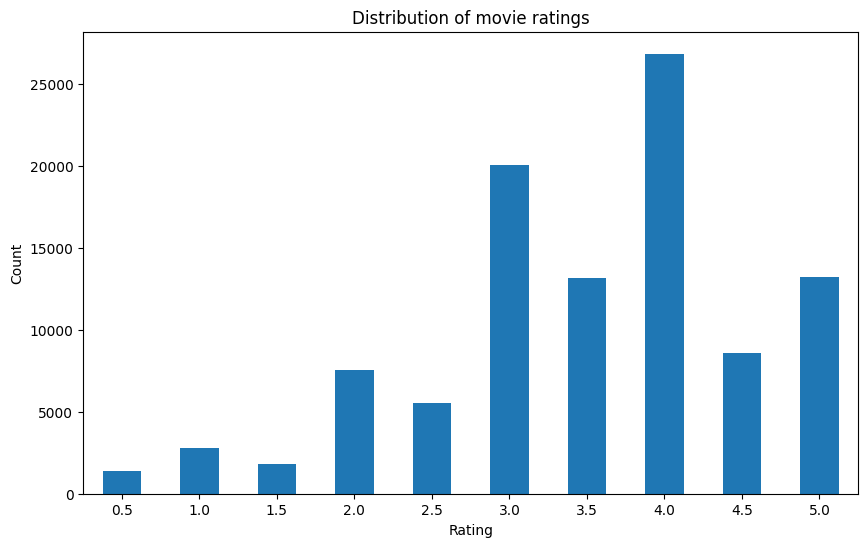

In [2]:
plt.figure(figsize=(10, 6))
ratings_distribution.plot(kind='bar')
plt.title('Distribution of movie ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [4]:
movie_titles = dict(zip(movies['movieId'],movies['title']))
movie_stats = ratings.groupby('movieId').agg(count=('rating', 'size'), mean=('rating', 'mean')).reset_index()
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
print(movie_stats.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


   movieId  count      mean  bayesian_avg_x  bayesian_avg_y
0        1    215  3.920930        3.890632        3.890632
1        2    110  3.431818        3.417227        3.417227
2        3     52  3.259615        3.260086        3.260086
3        4      7  2.357143        2.897612        2.897612
4        5     49  3.071429        3.104793        3.104793


In [10]:
from scipy.sparse import csr_matrix
def create_sparse(df):
  M = df['userId'].nunique()
  N = df['movieId'].nunique()
  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))
  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]
  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M,N))
  return X, user_mapper, movie_mapper, user_inv_mapper,movie_inv_mapper

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
X, user_mapper, movie_mapper, user_inv_mapper,movie_inv_mapper = create_sparse(ratings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz #scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings/n_total
sparsity_p = round(sparsity*100,2)
print(f"Matrix sparsity: {sparsity_p}%")
n_ratings_per_user = X.getnnz(axis=1)

Matrix sparsity: 1.7%


In [12]:
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    X = X.T
    neighbour_ids = []
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(1, k+1):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    return neighbour_ids

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz #scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings/n_total
sparsity_p = round(sparsity*100,2)
print(f"Matrix sparsity: {sparsity_p}%")
n_ratings_per_user = X.getnnz(axis=1)
n_ratings_per_user = X.getnnz(axis=1)
print("Amount of ratings per user:", n_ratings_per_user)

Matrix sparsity: 1.7%
Amount of ratings per user: [ 232   29   39  216   44  314  152   47   46  140   64   32   31   48
  135   98  105  502  703  242  443  119  121  110   26   21  135  570
   81   34   50  102  156   86   23   60   21   78  100  103  217  440
  114   48  399   42  140   33   21  310  359  130   20   33   25   46
  476  112  107   22   39  366  271  517   34  345   36 1260   46   62
   35   45  210  177   69  119   29   61   64  167   26  227  118  293
   34   70   21   56  518   54  575   24   97   56  168   78   36   92
   53  148   61   56  377  273  722   33   34   76  127   51  646   65
  150   31  112   87  165   22  215   22   58  292   56   50  360   38
   22   33  140   28   69  347   35   35  279  111  141   22  194  608
  168   38   71  128   23   32   20   48   58   26   59   63  179   34
   46  398   21   26   97  437   39   38   23   36   65  190  173   94
  269   50   82   26   25   67   24   36  904   77   69   24  118  977
   57  134   47  226  258  

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Toy Story Zadanie

In [25]:
toystory_id = movies[movies['title'].str.contains('Toy Story')]['movieId'].iloc[0]
similar_movies = find_similar_movies(toystory_id, X, movie_mapper, movie_inv_mapper, k=10, metric='cosine')
original_movie_title = movies[movies['movieId'] == toystory_id]['title'].values[0]
recommended_titles = movies[movies['movieId'].isin(similar_movies)]['title'].values
print(f"\nRekomendacje po obejrzeniu filmu '{original_movie_title}':")
for idx, title in enumerate(recommended_titles, 1):
    print(f"{idx}. {title}")


Rekomendacje po obejrzeniu filmu 'Toy Story (1995)':
1. Star Wars: Episode IV - A New Hope (1977)
2. Forrest Gump (1994)
3. Lion King, The (1994)
4. Jurassic Park (1993)
5. Mission: Impossible (1996)
6. Independence Day (a.k.a. ID4) (1996)
7. Star Wars: Episode VI - Return of the Jedi (1983)
8. Groundhog Day (1993)
9. Back to the Future (1985)
10. Toy Story 2 (1999)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Zadanie 1

In [26]:
num_children_movies = movies[movies['genres'].str.contains("Children")].shape[0]
print(f"Liczba filmów dla dzieci: {num_children_movies}")

Liczba filmów dla dzieci: 664


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Zadanie 2

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


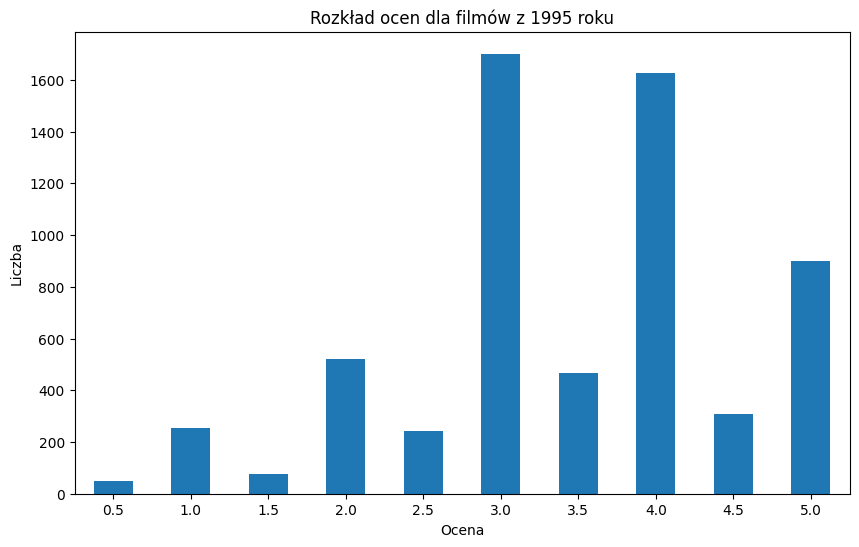

In [27]:
movies_1995 = movies[movies['title'].str.contains("1995")]
ratings_1995 = ratings[ratings['movieId'].isin(movies_1995['movieId'])]
rating_distribution_1995 = ratings_1995['rating'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
rating_distribution_1995.plot(kind='bar')
plt.title('Rozkład ocen dla filmów z 1995 roku')
plt.xlabel('Ocena')
plt.ylabel('Liczba')
plt.xticks(rotation=0)
plt.show()

Zadanie 3

In [28]:
action_movies = movies[movies['genres'].str.contains("Action")]
action_movie_ids = action_movies['movieId']
action_ratings = ratings[ratings['movieId'].isin(action_movie_ids)]
avg_action_rating = action_ratings['rating'].mean()
print(f"Średnia ocen wszystkich filmów akcji: {avg_action_rating:.2f}")
action_movie_avg_ratings = action_ratings.groupby('movieId')['rating'].mean().reset_index()
top_3_action_movies = action_movie_avg_ratings.nlargest(3, 'rating')
top_3_action_movies = top_3_action_movies.merge(movies[['movieId', 'title']], on='movieId')
print("Top 3 najwyżej oceniane filmy akcji:")
for idx, row in top_3_action_movies.iterrows():
    print(f"{idx + 1}. {row['title']} - Ocena: {row['rating']:.2f}")

Średnia ocen wszystkich filmów akcji: 3.45
Top 3 najwyżej oceniane filmy akcji:
1. Supercop 2 (Project S) (Chao ji ji hua) (1993) - Ocena: 5.00
2. Assignment, The (1997) - Ocena: 5.00
3. Knock Off (1998) - Ocena: 5.00


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
!pip install surprise
import pandas as pd
import time
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNBasic, KNNBaseline
from surprise import Dataset, Reader, accuracy

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357253 sha256=33c78e0b46409c0e8fca8b14ef313fc703fc1fda742a946e2f57857f652a1fa9
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [31]:
# Wczytywanie danych
ratings_data = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
min_rating_value = ratings_data.rating.min()
max_rating_value = ratings_data.rating.max()

# Przygotowanie danych
rating_reader = Reader(rating_scale=(min_rating_value, max_rating_value))
dataset = Dataset.load_from_df(ratings_data[['userId', 'movieId', 'rating']], rating_reader)
trainset, testset = train_test_split(dataset, test_size=0.25)

# Trening SVD
start_time_svd_train = time.time()
svd_algo = SVD()
svd_algo.fit(trainset)
svd_predictions = svd_algo.test(testset)
accuracy.rmse(svd_predictions)
end_time_svd_train = time.time()

# GridSearch dla SVD
svd_param_grid = {'n_factors': [1, 2, 5, 10, 50]}
start_time_svd_grid = time.time()
svd_grid_search = GridSearchCV(SVD, svd_param_grid, measures=['rmse'], cv=5, n_jobs=-1)
svd_grid_search.fit(dataset)
end_time_svd_grid = time.time()

best_svd_params = svd_grid_search.best_params
best_svd_algo = svd_grid_search.best_estimator['rmse']
svd_cross_val = cross_validate(best_svd_algo, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Trening KNN
start_time_knn_train = time.time()
knn_algo = KNNBasic()
knn_algo.fit(trainset)
knn_predictions = knn_algo.test(testset)
accuracy.rmse(knn_predictions)
end_time_knn_train = time.time()

# GridSearch dla KNN
knn_param_grid = {'k': [1, 2, 5, 10, 20, 30, 40, 50]}
start_time_knn_grid = time.time()
knn_grid_search = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse'], cv=5, n_jobs=-1)
knn_grid_search.fit(dataset)
end_time_knn_grid = time.time()

best_knn_params = knn_grid_search.best_params
best_knn_algo = knn_grid_search.best_estimator['rmse']
knn_cross_val = cross_validate(best_knn_algo, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Trening KNNBaseline
knn_baseline_algo = KNNBaseline()
knn_baseline_algo.fit(trainset)
knn_baseline_predictions = knn_baseline_algo.test(testset)
accuracy.rmse(knn_baseline_predictions)

# Walidacja krzyżowa KNN
start_time_knn_cross = time.time()
knn_cross_results = cross_validate(best_knn_algo, dataset, measures=['rmse'], cv=5, verbose=True)
end_time_knn_cross = time.time()

# Walidacja krzyżowa SVD
start_time_svd_cross = time.time()
svd_cross_results = cross_validate(best_svd_algo, dataset, measures=['rmse'], cv=5, verbose=True)
end_time_svd_cross = time.time()

# Wyniki i czasy wykonania
print(f"\nNajlepszy KNN RMSE: {knn_grid_search.best_score['rmse']}")
print(f"Najlepszy SVD RMSE: {svd_grid_search.best_score['rmse']}")
print(f"\nNajlepsze parametry KNN: {knn_grid_search.best_params['rmse']}")
print(f"Najlepsze parametry SVD: {svd_grid_search.best_params['rmse']}")
print(f"\nCzas trenowania hiperparametrów KNN: {end_time_knn_grid - start_time_knn_grid} sekund")
print(f"Czas trenowania hiperparametrów SVD: {end_time_svd_grid - start_time_svd_grid} sekund")
print(f"\nCzas trenowania KNN (cross-validation): {end_time_knn_cross - start_time_knn_cross} sekund")
print(f"Czas trenowania SVD (cross-validation): {end_time_svd_cross - start_time_svd_cross} sekund")
print(f"\nCzas trenowania SVD: {end_time_svd_train - start_time_svd_train} sekund")
print(f"Czas trenowania KNN: {end_time_knn_train - start_time_knn_train} sekund")
print(f"\nWyniki walidacji krzyżowej KNN: {knn_cross_results}")
print(f"Wyniki walidacji krzyżowej SVD: {svd_cross_results}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RMSE: 0.8809
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8658  0.8694  0.8683  0.8762  0.8654  0.8690  0.0039  
MAE (testset)     0.6647  0.6683  0.6655  0.6728  0.6686  0.6680  0.0029  
Fit time          0.75    1.00    0.77    0.86    0.96    0.87    0.10    
Test time         0.43    0.12    0.13    0.37    0.14    0.24    0.13    
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9576
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4